# U-Net for Supervised Image Denoising (30k Images)

This notebook trains a U-Net model for supervised image denoising, configured for a dataset of approximately 30,000 images.

**Features:**
- U-Net architecture suitable for image restoration.
- Handles large datasets by splitting into Training and Validation sets.
- Implements Validation loop to monitor generalization.
- Uses Learning Rate Scheduling (`ReduceLROnPlateau`) based on validation loss.
- Saves the best model checkpoint based on validation performance.
- Implements Early Stopping to prevent overfitting and save time.
- Includes a Testing section to load the best model and denoise a sample image.

## Imports

In [25]:
import os
import glob
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # Use standard tqdm if not in notebook: from tqdm import tqdm
import time
import copy # For potentially saving best model state if needed differently

import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from sklearn.model_selection import train_test_split # For splitting data

## Configuration Parameters

In [26]:
# --- File Paths and Names ---
DATA_DIR = '/kaggle/input/aiml-project/train_images_500' # <<< !!! CHANGE THIS to the path of your 30k images !!!
TEST_IMG_DIR = '/kaggle/input/aiml-project/test_images_50'   # Directory containing test images (used in Section 3)
MODEL_SAVE_DIR = '/kaggle/working/'            # Directory to save the best model checkpoint

# --- Image Parameters ---
IMG_SIZE = 256 # Keep at 128 initially for 4GB VRAM, or decrease further if needed.
N_IMG_CHANNELS = 3 # Input/Output channels (3 for RGB)

# --- Training Parameters ---
VAL_SPLIT_RATIO = 0.15 # Fraction of data for validation (15% of 30k is 4.5k images)
BATCH_SIZE = 16     # <<< !!! START WITH 8 or 16 for 4GB VRAM! MONITOR MEMORY & ADJUST IF NEEDED! !!!
LEARNING_RATE = 1e-4
EPOCHS = 100        # Max number of epochs (Early Stopping will likely stop sooner)
NOISE_TYPE = 'poiss'# Noise type for training data: 'gauss' or 'poiss'
NOISE_LEVEL = 15    # Noise level for training (0-255 for Gauss, 0-1 scale for Poisson)

BEST_MODEL_NAME = NOISE_TYPE+'_n2n_nl'+f'{NOISE_LEVEL}'+'_best.pth' # Name for the best model checkpoint


# --- Early Stopping & LR Scheduler ---
EARLY_STOPPING_PATIENCE = 10 # Stop if validation loss doesn't improve for this many epochs
LR_SCHEDULER_PATIENCE = 5  # Reduce LR if validation loss doesn't improve for this many epochs
LR_SCHEDULER_FACTOR = 0.2  # Factor to reduce LR by (new_lr = lr * factor)

# --- U-Net Parameters ---
INIT_FEATURES = 64 # Number of features/channels in the first layer of U-Net
BILINEAR_UPSAMPLE = True # Use bilinear upsampling in U-Net

# --- System Parameters ---
NUM_WORKERS = 0 # Number of workers for DataLoader (adjust based on CPU cores)

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Directory Setup ---
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(TEST_IMG_DIR, exist_ok=True)

# --- Reproducibility (Optional) ---
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using device: cuda


## Helper Functions (Preprocessing & Noise)

In [27]:
def preprocess_image(image_path, img_size):
    """Loads, resizes, normalizes, and converts image to PyTorch tensor."""
    try:
        img = Image.open(image_path).convert('RGB')
        img = TF.resize(img, [img_size, img_size], interpolation=TF.InterpolationMode.BILINEAR)
        img_tensor = TF.to_tensor(img)
        if img_tensor.shape[0] != N_IMG_CHANNELS:
             if N_IMG_CHANNELS == 1 and img_tensor.shape[0] == 3: img_tensor = TF.rgb_to_grayscale(img_tensor)
             elif N_IMG_CHANNELS == 3 and img_tensor.shape[0] == 1: img_tensor = TF.grayscale_to_rgb(img_tensor)
             else:
                 print(f"Warning: Channel mismatch for {image_path}. Skipping.")
                 return None
        return img_tensor
    except Exception as e:
        print(f"Error processing {image_path}: {e}. Skipping.")
        return None

def add_noise(x, noise_type='gauss', noise_level=25):
    """Adds Gaussian or Poisson noise to a clean image tensor (range [0, 1])."""
    if noise_type == 'gauss':
        std_dev = noise_level / 255.0
        noisy = x + torch.randn_like(x) * std_dev
    elif noise_type == 'poiss':
        noisy = torch.poisson(noise_level * x) / noise_level
    else: # Unknown noise type
        print(f"Warning: Unknown noise type '{noise_type}'. Returning original image.")
        noisy = x
    return torch.clamp(noisy, 0.0, 1.0)

## U-Net Model Definition

In [28]:
class DoubleConv(nn.Module):
    """(Convolution => [BatchNorm] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels: mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels), nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with MaxPool then DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_channels, out_channels))
    def forward(self, x): return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then DoubleConv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]; diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__(); self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x): return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, init_features=64, bilinear=True):
        super(UNet, self).__init__(); self.n_channels = n_channels; self.n_classes = n_classes; self.bilinear = bilinear
        factor = 2 if bilinear else 1
        self.inc = DoubleConv(n_channels, init_features)
        self.down1 = Down(init_features, init_features * 2); self.down2 = Down(init_features * 2, init_features * 4)
        self.down3 = Down(init_features * 4, init_features * 8); self.down4 = Down(init_features * 8, init_features * 16 // factor)
        self.up1 = Up(init_features * 16, init_features * 8 // factor, bilinear); self.up2 = Up(init_features * 8, init_features * 4 // factor, bilinear)
        self.up3 = Up(init_features * 4, init_features * 2 // factor, bilinear); self.up4 = Up(init_features * 2, init_features, bilinear)
        self.outc = OutConv(init_features, n_classes)
    def forward(self, x):
        x1 = self.inc(x); x2 = self.down1(x1); x3 = self.down2(x2); x4 = self.down3(x3); x5 = self.down4(x4)
        x = self.up1(x5, x4); x = self.up2(x, x3); x = self.up3(x, x2); x = self.up4(x, x1); logits = self.outc(x)
        return logits

## Dataset Definition

In [29]:
class DenoisingImageDataset(Dataset):
    def __init__(self, image_paths, img_size, noise_type, noise_level, transform=None):
        self.image_paths = image_paths; self.img_size = img_size; self.noise_type = noise_type
        self.noise_level = noise_level; self.transform = transform
    def __len__(self): return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            clean_img_tensor = preprocess_image(img_path, self.img_size)
            if clean_img_tensor is None:
                print(f"Warning: Skipping item {idx} due to preprocessing error, trying random next.")
                return self.__getitem__(random.randint(0, len(self) - 1))
            # Apply transformations if any (applied identically) - complex, omitted here
            noisy_input = add_noise(clean_img_tensor, self.noise_type, self.noise_level)
            noisy_target = add_noise(clean_img_tensor, self.noise_type, self.noise_level)
            return noisy_input, noisy_target
        except Exception as e:
            print(f"Error in __getitem__ for index {idx}, path {img_path}: {e}")
            return self.__getitem__(random.randint(0, len(self) - 1)) # Return random different item on error

## Section 1: Data Loading and Preparation

In [30]:
print("--- Phase 1: Data Loading and Preparation ---")
all_image_paths = glob.glob(os.path.join(DATA_DIR, '*.[jJ][pP][gG]')) \
                 + glob.glob(os.path.join(DATA_DIR, '*.[pP][nN][gG]')) \
                 + glob.glob(os.path.join(DATA_DIR, '*.[tT][iI][fF][fF]')) # Add more if needed

if not all_image_paths:
    print(f"Error: No images found in '{DATA_DIR}'. Please ensure the path is correct and contains images.")
    # Or raise an error: raise FileNotFoundError(f"No images found in {DATA_DIR}")
else:
    print(f"Found {len(all_image_paths)} total images in '{DATA_DIR}'.")

    # Split paths into training and validation sets
    train_paths, val_paths = train_test_split(all_image_paths, test_size=VAL_SPLIT_RATIO, random_state=42)
    print(f"Using {len(train_paths)} images for training, {len(val_paths)} for validation.")

    # Create Datasets
    train_dataset = DenoisingImageDataset(train_paths, IMG_SIZE, NOISE_TYPE, NOISE_LEVEL)
    val_dataset = DenoisingImageDataset(val_paths, IMG_SIZE, NOISE_TYPE, NOISE_LEVEL)

    # Create DataLoaders
    pin_mem = True if device == torch.device("cuda") else False
    # persistent_workers=True can speed up epoch start after the first one if num_workers > 0
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                  num_workers=NUM_WORKERS, pin_memory=pin_mem, persistent_workers=(NUM_WORKERS > 0))
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                num_workers=NUM_WORKERS, pin_memory=pin_mem, persistent_workers=(NUM_WORKERS > 0))

    print("DataLoaders created.")


--- Phase 1: Data Loading and Preparation ---
Found 500 total images in '/kaggle/input/aiml-project/train_images_500'.
Using 425 images for training, 75 for validation.
DataLoaders created.


## Section 2: Model Training

In [31]:
# --- Initialize Model, Loss, Optimizer, Scheduler ---
print("\n--- Phase 2: Model Training ---")
# Ensure DataLoaders were created before proceeding
if 'train_dataloader' not in locals() or 'val_dataloader' not in locals():
     print("DataLoaders not available. Please ensure Section 1 ran successfully and found images.")
else:
    model = UNet(n_channels=N_IMG_CHANNELS, n_classes=N_IMG_CHANNELS, init_features=INIT_FEATURES, bilinear=BILINEAR_UPSAMPLE).to(device)
    print(f"U-Net Model Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=LR_SCHEDULER_FACTOR, patience=LR_SCHEDULER_PATIENCE, verbose=True)

    # --- Variables for tracking best model and early stopping ---
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_path = os.path.join(MODEL_SAVE_DIR, BEST_MODEL_NAME)
    train_losses, val_losses = [], [] # Store losses for plotting


--- Phase 2: Model Training ---
U-Net Model Parameters: 17,263,107


Starting training loop...


Epoch 1/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 1/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/100 - Train Loss: 0.189165, Val Loss: 0.184857
Val loss improved (inf --> 0.184857). Saving model to /kaggle/working/poiss_n2n_nl15_best.pth


Epoch 2/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 2/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/100 - Train Loss: 0.053538, Val Loss: 0.046115
Val loss improved (0.184857 --> 0.046115). Saving model to /kaggle/working/poiss_n2n_nl15_best.pth


Epoch 3/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 3/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/100 - Train Loss: 0.033741, Val Loss: 0.032329
Val loss improved (0.046115 --> 0.032329). Saving model to /kaggle/working/poiss_n2n_nl15_best.pth


Epoch 4/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 4/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/100 - Train Loss: 0.031447, Val Loss: 0.031701
Val loss improved (0.032329 --> 0.031701). Saving model to /kaggle/working/poiss_n2n_nl15_best.pth


Epoch 5/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 5/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/100 - Train Loss: 0.030383, Val Loss: 0.029896
Val loss improved (0.031701 --> 0.029896). Saving model to /kaggle/working/poiss_n2n_nl15_best.pth


Epoch 6/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 6/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6/100 - Train Loss: 0.029735, Val Loss: 0.029211
Val loss improved (0.029896 --> 0.029211). Saving model to /kaggle/working/poiss_n2n_nl15_best.pth


Epoch 7/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 7/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7/100 - Train Loss: 0.029616, Val Loss: 0.028955
Val loss improved (0.029211 --> 0.028955). Saving model to /kaggle/working/poiss_n2n_nl15_best.pth


Epoch 8/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 8/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8/100 - Train Loss: 0.029149, Val Loss: 0.028574
Val loss improved (0.028955 --> 0.028574). Saving model to /kaggle/working/poiss_n2n_nl15_best.pth


Epoch 9/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 9/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9/100 - Train Loss: 0.028840, Val Loss: 0.043527
Val loss did not improve for 1 epoch(s).


Epoch 10/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 10/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.028764, Val Loss: 0.029745
Val loss did not improve for 2 epoch(s).


Epoch 11/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 11/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11/100 - Train Loss: 0.028343, Val Loss: 0.028308
Val loss improved (0.028574 --> 0.028308). Saving model to /kaggle/working/poiss_n2n_nl15_best.pth


Epoch 12/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 12/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12/100 - Train Loss: 0.028510, Val Loss: 0.028599
Val loss did not improve for 1 epoch(s).


Epoch 13/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 13/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13/100 - Train Loss: 0.027964, Val Loss: 0.029409
Val loss did not improve for 2 epoch(s).


Epoch 14/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 14/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14/100 - Train Loss: 0.028201, Val Loss: 0.027783
Val loss improved (0.028308 --> 0.027783). Saving model to /kaggle/working/poiss_n2n_nl15_best.pth


Epoch 15/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 15/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/100 - Train Loss: 0.028585, Val Loss: 0.091331
Val loss did not improve for 1 epoch(s).


Epoch 16/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 16/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16/100 - Train Loss: 0.028527, Val Loss: 0.028598
Val loss did not improve for 2 epoch(s).


Epoch 17/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 17/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17/100 - Train Loss: 0.027893, Val Loss: 0.027848
Val loss did not improve for 3 epoch(s).


Epoch 18/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 18/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18/100 - Train Loss: 0.028245, Val Loss: 0.029734
Val loss did not improve for 4 epoch(s).


Epoch 19/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 19/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19/100 - Train Loss: 0.028292, Val Loss: 0.027828
Val loss did not improve for 5 epoch(s).


Epoch 20/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 20/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.027987, Val Loss: 0.028066
Val loss did not improve for 6 epoch(s).


Epoch 21/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 21/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21/100 - Train Loss: 0.027907, Val Loss: 0.027646
Val loss improved (0.027783 --> 0.027646). Saving model to /kaggle/working/poiss_n2n_nl15_best.pth


Epoch 22/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 22/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22/100 - Train Loss: 0.027859, Val Loss: 0.027570
Val loss improved (0.027646 --> 0.027570). Saving model to /kaggle/working/poiss_n2n_nl15_best.pth


Epoch 23/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 23/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23/100 - Train Loss: 0.027839, Val Loss: 0.027496
Val loss improved (0.027570 --> 0.027496). Saving model to /kaggle/working/poiss_n2n_nl15_best.pth


Epoch 24/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 24/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24/100 - Train Loss: 0.027650, Val Loss: 0.027626
Val loss did not improve for 1 epoch(s).


Epoch 25/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 25/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25/100 - Train Loss: 0.027571, Val Loss: 0.027464
Val loss improved (0.027496 --> 0.027464). Saving model to /kaggle/working/poiss_n2n_nl15_best.pth


Epoch 26/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 26/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26/100 - Train Loss: 0.027756, Val Loss: 0.027424
Val loss improved (0.027464 --> 0.027424). Saving model to /kaggle/working/poiss_n2n_nl15_best.pth


Epoch 27/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 27/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27/100 - Train Loss: 0.027871, Val Loss: 0.027479
Val loss did not improve for 1 epoch(s).


Epoch 28/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 28/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28/100 - Train Loss: 0.027632, Val Loss: 0.027720
Val loss did not improve for 2 epoch(s).


Epoch 29/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 29/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29/100 - Train Loss: 0.027603, Val Loss: 0.027583
Val loss did not improve for 3 epoch(s).


Epoch 30/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 30/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.027873, Val Loss: 0.027749
Val loss did not improve for 4 epoch(s).


Epoch 31/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 31/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31/100 - Train Loss: 0.027855, Val Loss: 0.027682
Val loss did not improve for 5 epoch(s).


Epoch 32/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 32/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32/100 - Train Loss: 0.027348, Val Loss: 0.027526
Val loss did not improve for 6 epoch(s).


Epoch 33/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 33/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33/100 - Train Loss: 0.027301, Val Loss: 0.027469
Val loss did not improve for 7 epoch(s).


Epoch 34/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 34/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34/100 - Train Loss: 0.027551, Val Loss: 0.027441
Val loss did not improve for 8 epoch(s).


Epoch 35/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 35/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35/100 - Train Loss: 0.027587, Val Loss: 0.027568
Val loss did not improve for 9 epoch(s).


Epoch 36/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 36/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36/100 - Train Loss: 0.027255, Val Loss: 0.027390
Val loss improved (0.027424 --> 0.027390). Saving model to /kaggle/working/poiss_n2n_nl15_best.pth


Epoch 37/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 37/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37/100 - Train Loss: 0.027176, Val Loss: 0.027416
Val loss did not improve for 1 epoch(s).


Epoch 38/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 38/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38/100 - Train Loss: 0.027331, Val Loss: 0.027367
Val loss improved (0.027390 --> 0.027367). Saving model to /kaggle/working/poiss_n2n_nl15_best.pth


Epoch 39/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 39/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39/100 - Train Loss: 0.027290, Val Loss: 0.027417
Val loss did not improve for 1 epoch(s).


Epoch 40/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 40/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.027407, Val Loss: 0.027454
Val loss did not improve for 2 epoch(s).


Epoch 41/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 41/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41/100 - Train Loss: 0.027323, Val Loss: 0.027470
Val loss did not improve for 3 epoch(s).


Epoch 42/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 42/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42/100 - Train Loss: 0.027186, Val Loss: 0.027410
Val loss did not improve for 4 epoch(s).


Epoch 43/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 43/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43/100 - Train Loss: 0.027201, Val Loss: 0.027346
Val loss improved (0.027367 --> 0.027346). Saving model to /kaggle/working/poiss_n2n_nl15_best.pth


Epoch 44/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 44/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44/100 - Train Loss: 0.027228, Val Loss: 0.027329
Val loss improved (0.027346 --> 0.027329). Saving model to /kaggle/working/poiss_n2n_nl15_best.pth


Epoch 45/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 45/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45/100 - Train Loss: 0.027192, Val Loss: 0.027411
Val loss did not improve for 1 epoch(s).


Epoch 46/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 46/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46/100 - Train Loss: 0.027213, Val Loss: 0.027440
Val loss did not improve for 2 epoch(s).


Epoch 47/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 47/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47/100 - Train Loss: 0.027123, Val Loss: 0.027415
Val loss did not improve for 3 epoch(s).


Epoch 48/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 48/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48/100 - Train Loss: 0.027269, Val Loss: 0.027433
Val loss did not improve for 4 epoch(s).


Epoch 49/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 49/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49/100 - Train Loss: 0.027541, Val Loss: 0.027338
Val loss did not improve for 5 epoch(s).


Epoch 50/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 50/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.027040, Val Loss: 0.027338
Val loss did not improve for 6 epoch(s).


Epoch 51/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 51/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 51/100 - Train Loss: 0.027240, Val Loss: 0.027364
Val loss did not improve for 7 epoch(s).


Epoch 52/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 52/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 52/100 - Train Loss: 0.027392, Val Loss: 0.027475
Val loss did not improve for 8 epoch(s).


Epoch 53/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 53/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 53/100 - Train Loss: 0.027368, Val Loss: 0.027334
Val loss did not improve for 9 epoch(s).


Epoch 54/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 54/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 54/100 - Train Loss: 0.027256, Val Loss: 0.027393
Val loss did not improve for 10 epoch(s).
Early stopping triggered after 54 epochs.
Training Finished. Total time: 25.68 minutes
Best Validation Loss achieved: 0.027329


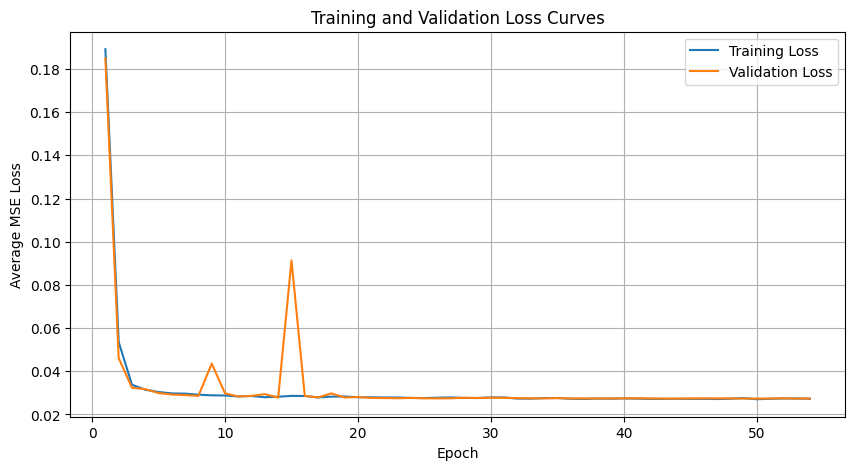

In [32]:
# --- Training Loop ---
print("Starting training loop...")
start_time = time.time()

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train()
    running_train_loss = 0.0
    train_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False)
    for noisy_batch, clean_batch in train_progress_bar:
        noisy_batch = noisy_batch.to(device); clean_batch = clean_batch.to(device)
        optimizer.zero_grad(); predicted_clean_batch = model(noisy_batch)
        loss = criterion(predicted_clean_batch, clean_batch)
        loss.backward(); optimizer.step()
        running_train_loss += loss.item() * noisy_batch.size(0)
        train_progress_bar.set_postfix(loss=f"{loss.item():.6f}")
    avg_train_loss = running_train_loss / len(train_dataset)
    train_losses.append(avg_train_loss)

    # --- Validation Phase ---
    model.eval(); running_val_loss = 0.0
    val_progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", leave=False)
    with torch.no_grad():
        for noisy_batch, clean_batch in val_progress_bar:
            noisy_batch = noisy_batch.to(device); clean_batch = clean_batch.to(device)
            predicted_clean_batch = model(noisy_batch)
            loss = criterion(predicted_clean_batch, clean_batch)
            running_val_loss += loss.item() * noisy_batch.size(0)
            val_progress_bar.set_postfix(loss=f"{loss.item():.6f}")
    avg_val_loss = running_val_loss / len(val_dataset)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

    # --- LR Scheduling, Checkpointing, Early Stopping ---
    scheduler.step(avg_val_loss)
    if avg_val_loss < best_val_loss:
        print(f"Val loss improved ({best_val_loss:.6f} --> {avg_val_loss:.6f}). Saving model to {best_model_path}")
        best_val_loss = avg_val_loss
        try: torch.save(model.state_dict(), best_model_path)
        except Exception as e: print(f"Error saving model: {e}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1; print(f"Val loss did not improve for {epochs_no_improve} epoch(s).")
    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

# --- Training Finished ---
end_time = time.time()
print(f"Training Finished. Total time: {(end_time - start_time)/60:.2f} minutes")
print(f"Best Validation Loss achieved: {best_val_loss:.6f}")

# --- Plot Loss Curves ---
plt.figure(figsize=(10, 5)); plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss'); plt.xlabel('Epoch'); plt.ylabel('Average MSE Loss')
plt.title('Training and Validation Loss Curves'); plt.legend(); plt.grid(True); plt.show()

## Section 3: Testing


In [33]:
# --- Parameters for Testing ---
SAVED_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, BEST_MODEL_NAME) # Uses the best model saved
TEST_IMAGE_PATH = '/kaggle/input/aiml-project/491.jpg' # <<< CHANGE to your test image name
TEST_IMAGE_IS_ALREADY_NOISY = False # <<< SET according to your test image
TEST_NOISE_TYPE = NOISE_TYPE           # Use same noise type as training ideally
TEST_NOISE_LEVEL = NOISE_LEVEL               # Use same noise level as training ideally
DENOISE_N_TIMES = 1              # Number of times to denoise the image (1 or more)


In [34]:
# --- Load Best Model ---
print("\n--- Phase 3: Testing ---")
print(f"Loading best model from: {SAVED_MODEL_PATH}")
testing_model_loaded = False
try:
    test_model = UNet(n_channels=N_IMG_CHANNELS, n_classes=N_IMG_CHANNELS, init_features=INIT_FEATURES, bilinear=BILINEAR_UPSAMPLE).to(device)
    test_model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=device))
    test_model.eval() # Set model to evaluation mode
    print("Best model loaded successfully.")
    testing_model_loaded = True
except FileNotFoundError:
    print(f"Error: Best model file not found at {SAVED_MODEL_PATH}. Cannot perform testing.")
except Exception as e:
    print(f"Error loading model state_dict: {e}. Cannot perform testing.")


--- Phase 3: Testing ---
Loading best model from: /kaggle/working/poiss_n2n_nl15_best.pth
Best model loaded successfully.


/tmp/ipykernel_31/655531011.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=device))


Loading test image: /kaggle/input/aiml-project/491.jpg
Adding poiss noise (level 15) to the test image.
Denoising (1 pass(es))...
Denoising complete.
PSNR (Noisy vs Clean): 15.65 dB
PSNR (Final Denoised vs Clean): 21.64 dB


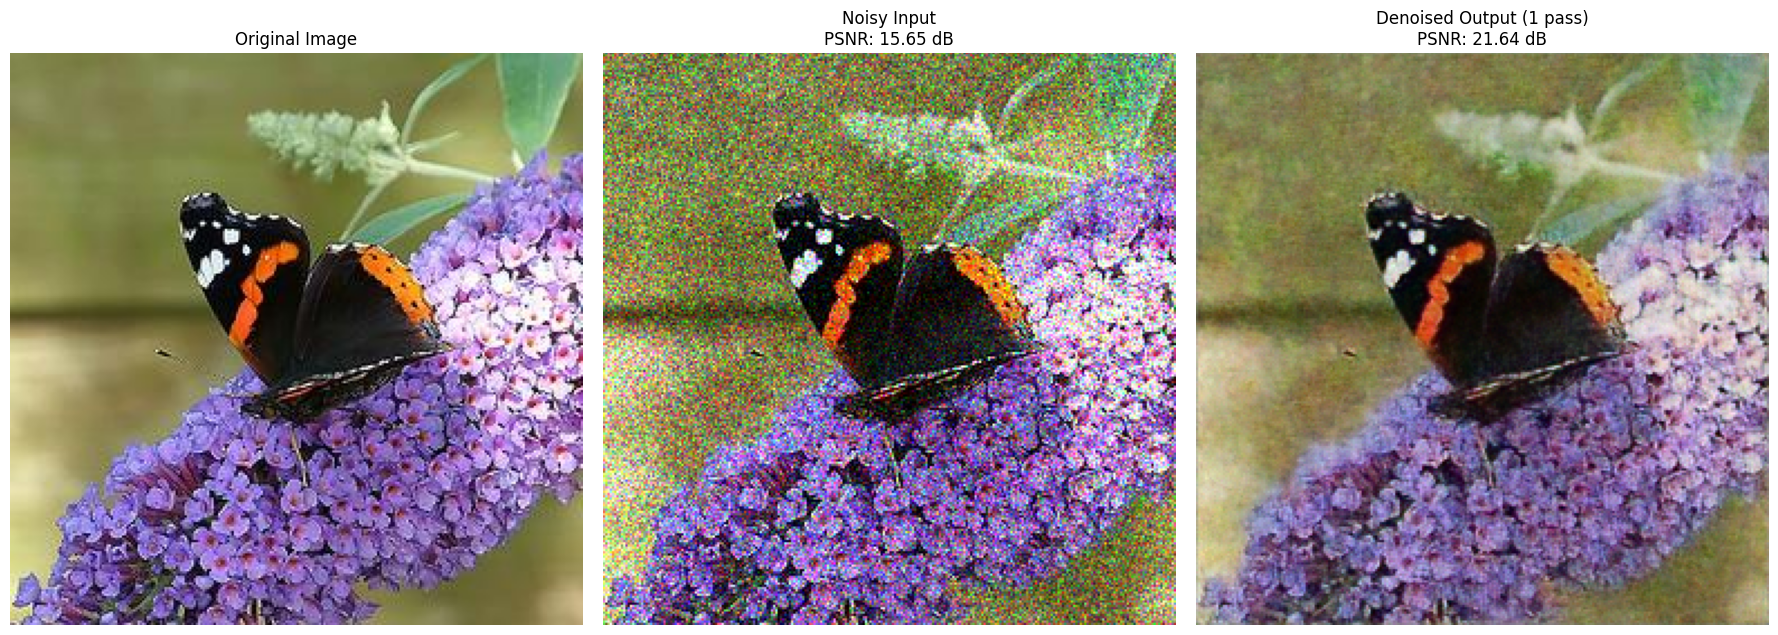

In [35]:
# NOTEBOOK CELL 3 (Updated with PSNR in plot titles)

# --- Load, Prepare, and Denoise Test Image ---
if testing_model_loaded:
    print(f"Loading test image: {TEST_IMAGE_PATH}")
    if not os.path.exists(TEST_IMAGE_PATH):
          print(f"Error: Test image not found at {TEST_IMAGE_PATH}")
          # Handle error or create dummy as before
          # For this example, assume we stop if not found, or handle appropriately
          input_tensor = None
    else:
        # Assume preprocess_image returns a CPU tensor [0,1] float CHW
        input_tensor_cpu = preprocess_image(TEST_IMAGE_PATH, IMG_SIZE)
        if input_tensor_cpu is None:
            input_tensor = None
            print("Error: Failed to preprocess test image.")
        else:
            input_tensor = input_tensor_cpu.to(device) # Move clean tensor to device

    if input_tensor is not None:
        # Keep a CPU copy of the original clean tensor for display later
        original_for_display = input_tensor.cpu().clone()

        # --- Prepare Noisy Input ---
        if not TEST_IMAGE_IS_ALREADY_NOISY:
            print(f"Adding {TEST_NOISE_TYPE} noise (level {TEST_NOISE_LEVEL}) to the test image.")
            # Assume add_noise returns tensor on the same device as input
            noisy_input_tensor = add_noise(input_tensor, TEST_NOISE_TYPE, TEST_NOISE_LEVEL)
        else:
            print("Test image is assumed to be already noisy.")
            noisy_input_tensor = input_tensor # Use the loaded tensor directly

        noisy_input_batch = noisy_input_tensor.unsqueeze(0) # Add batch dimension B=1

        # --- Perform Denoising (Potentially Multiple Passes) ---
        print(f"Denoising ({DENOISE_N_TIMES} pass(es))...")
        current_denoised_tensor = noisy_input_tensor # Start with noisy input for the first pass if DENOISE_N_TIMES > 0
        try:
            with torch.no_grad():
                # Initial pass
                current_denoised_batch = test_model(current_denoised_tensor.unsqueeze(0))
                current_denoised_tensor = torch.clamp(current_denoised_batch.squeeze(0), 0.0, 1.0)

                # Subsequent passes if DENOISE_N_TIMES > 1
                for i in range(DENOISE_N_TIMES - 1):
                    # print(f"  Denoising pass {i+2}/{DENOISE_N_TIMES}...") # Optional verbose output
                    current_denoised_batch = test_model(current_denoised_tensor.unsqueeze(0))
                    current_denoised_tensor = torch.clamp(current_denoised_batch.squeeze(0), 0.0, 1.0)

            # Final denoised tensor is stored in current_denoised_tensor
            denoised_output_tensor = current_denoised_tensor # Assign final result
            print("Denoising complete.")

        except Exception as e:
            print(f"An error occurred during denoising: {e}")
            denoised_output_tensor = None # Ensure it's None if denoising failed

        # --- Calculate PSNR and Display Results ---
        if denoised_output_tensor is not None:
            # --- Calculate PSNR Values ---
            # Ensure comparison tensors are on the correct device
            clean_tensor_device = original_for_display.to(device) # Move original clean CPU tensor to device
            # noisy_input_tensor and denoised_output_tensor are already on device

            # PSNR for Noisy vs Clean
            mse_noisy = F.mse_loss(noisy_input_tensor, clean_tensor_device)
            if mse_noisy.item() > 1e-10:
                psnr_noisy = 10 * torch.log10(1.0 / mse_noisy).item()
            else:
                psnr_noisy = float('inf')

            # PSNR for Final Denoised vs Clean
            mse_denoised = F.mse_loss(denoised_output_tensor, clean_tensor_device)
            if mse_denoised.item() > 1e-10:
                psnr_denoised = 10 * torch.log10(1.0 / mse_denoised).item()
            else:
                psnr_denoised = float('inf')

            print(f"PSNR (Noisy vs Clean): {psnr_noisy:.2f} dB")
            print(f"PSNR (Final Denoised vs Clean): {psnr_denoised:.2f} dB")

            # --- Prepare Tensors for Display (move to CPU, permute) ---
            noisy_display = noisy_input_tensor.cpu().permute(1, 2, 0).numpy()
            denoised_display = denoised_output_tensor.cpu().permute(1, 2, 0).numpy()
            original_display = original_for_display.permute(1, 2, 0).numpy() # Already on CPU

            # --- Plotting ---
            fig, ax = plt.subplots(1, 3, figsize=(18, 7)) # Adjusted size slightly

            ax[0].imshow(np.clip(original_display, 0, 1))
            ax[0].set_title('Original Image')
            ax[0].axis('off')

            ax[1].imshow(np.clip(noisy_display, 0, 1))
            # Updated title with PSNR
            ax[1].set_title(f'Noisy Input\nPSNR: {psnr_noisy:.2f} dB')
            ax[1].axis('off')

            ax[2].imshow(np.clip(denoised_display, 0, 1))
            # Updated title with PSNR and pass count
            denoised_title = f'Denoised Output ({DENOISE_N_TIMES} pass'
            denoised_title += 'es)' if DENOISE_N_TIMES > 1 else ')'
            denoised_title += f'\nPSNR: {psnr_denoised:.2f} dB'
            ax[2].set_title(denoised_title)
            ax[2].axis('off')

            plt.tight_layout(pad=1.5)
            plt.show()

        else:
            print("Skipping result display as denoising did not complete successfully.")
    else:
        print("Skipping testing phase as test image could not be loaded/processed.")
else:
    print("Skipping testing phase as model could not be loaded.")

In [36]:
# -*- coding: utf-8 -*-
import os
import time
import pandas as pd # For saving results to CSV
import numpy as np # For calculating average PSNR

import torch
import torch.nn as nn # Assuming UNet uses this
import torch.nn.functional as F # For mse_loss

# NOTE: Ensure necessary libraries like os, torch, pandas, numpy are imported.
# Assume the following are defined earlier in your script:
# - device = 'cuda' or 'cpu'
# - UNet class definition (or the correct model class)
# - preprocess_image(image_path, img_size) function
# - add_noise(image_tensor, noise_type, noise_level, device) function
# - IMG_SIZE (e.g., 256)
# - N_IMG_CHANNELS (e.g., 3)
# - INIT_FEATURES (parameter for UNet)
# - BILINEAR_UPSAMPLE (parameter for UNet)
# - MODEL_SAVE_DIR (e.g., './models')
# - BEST_MODEL_NAME (e.g., 'best_model_epoch_X.pth')

# --- Configuration for Batch Testing ---
TEST_IMG_DIR = '/kaggle/input/aiml-project/test_images_50' # Directory containing the 50 test images
CSV_OUTPUT_FILENAME = NOISE_TYPE+'_n2n_nl'+f'{NOISE_LEVEL}'+'_psnr.csv' # Output CSV filename for this test

# --- Iterative Denoising Parameter ---
# How many times to apply the denoising model sequentially
DENOISE_N_TIMES = 1  # As specified in the original Cell 1 for single image

# --- Noise Parameters for Testing ---
# Noise to ADD to the CLEAN test images. Should ideally match training conditions.
TEST_NOISE_TYPE = NOISE_TYPE # Example: match training
TEST_NOISE_LEVEL = NOISE_LEVEL     # Example: match training (high noise level specified)

# --- Construct Model Path (using assumed variables) ---
# Ensure BEST_MODEL_NAME is defined appropriately earlier
SAVED_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, BEST_MODEL_NAME)

# --- Load Best Model (Once) ---
print("\n--- Preparing for Batch Testing ---")
print(f"Loading best model from: {SAVED_MODEL_PATH}")
testing_model_loaded = False
try:
    # Instantiate the model architecture (ensure parameters are correct)
    test_model = UNet(
        n_channels=N_IMG_CHANNELS,
        n_classes=N_IMG_CHANNELS, # Output channels usually same as input for denoising
        init_features=INIT_FEATURES,
        bilinear=BILINEAR_UPSAMPLE
    ).to(device)
    # Load the trained weights
    test_model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=device))
    test_model.eval() # Set model to evaluation mode (crucial!)
    print("Best model loaded successfully.")
    testing_model_loaded = True
except FileNotFoundError:
    print(f"Error: Best model file not found at {SAVED_MODEL_PATH}. Cannot perform testing.")
    # Decide how to handle: exit, raise, etc.
    raise FileNotFoundError(f"Model file not found at {SAVED_MODEL_PATH}")
except Exception as e:
    print(f"Error loading model state_dict: {e}. Cannot perform testing.")
    raise e # Re-raise

# --- Prepare for Batch Processing ---
if not testing_model_loaded:
    print("Exiting script as model could not be loaded.")
    exit() # Or handle differently

if not os.path.isdir(TEST_IMG_DIR):
    print(f"Error: Test image directory not found: {TEST_IMG_DIR}")
    raise FileNotFoundError(f"Test image directory not found: {TEST_IMG_DIR}")

# Get list of image files
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
try:
    all_files = os.listdir(TEST_IMG_DIR)
    image_files = sorted([f for f in all_files if f.lower().endswith(image_extensions)])
except Exception as e:
    print(f"Error listing files in {TEST_IMG_DIR}: {e}")
    raise

if not image_files:
    print(f"No image files with extensions {image_extensions} found in {TEST_IMG_DIR}")
    exit()

print(f"Found {len(image_files)} images to process in {TEST_IMG_DIR}.")

# --- Initialize Results Storage ---
results_data = [] # List to hold {'filename': ..., 'psnr_db': ...} dictionaries

# --- Process Each Image in the Directory ---
print(f"\nStarting batch denoising ({DENOISE_N_TIMES} passes per image) and PSNR calculation...")
start_time = time.time() # Optional: time the process

for filename in image_files:
    current_image_path = os.path.join(TEST_IMG_DIR, filename)
    print(f"Processing: {filename}...")

    try:
        # --- Load and Prepare Clean Test Image ---
        # Assumes preprocess_image loads, resizes to IMG_SIZE, returns [0,1] float CHW tensor (on CPU)
        clean_input_tensor_cpu = preprocess_image(current_image_path, IMG_SIZE)
        if clean_input_tensor_cpu is None:
            print(f"  Skipping {filename} due to preprocessing error.")
            results_data.append({'filename': filename, 'psnr_db': np.nan}) # Record error
            continue # Skip to next image

        clean_input_tensor = clean_input_tensor_cpu.to(device) # Move clean tensor to device

        # --- Add Noise ---
        # Assuming all images in the test dir are clean, add noise specified by TEST_NOISE_* vars
        # Assumes add_noise returns tensor on the specified device
        noisy_input_tensor = add_noise(clean_input_tensor, TEST_NOISE_TYPE, TEST_NOISE_LEVEL)

        # --- Perform Iterative Denoising ---
        current_tensor = noisy_input_tensor # Start with the noisy image for the first pass
        with torch.no_grad(): # Ensure no gradients are computed
            for pass_num in range(DENOISE_N_TIMES):
                # Add batch dimension, process, remove batch dimension, clamp
                input_batch = current_tensor.unsqueeze(0)
                output_batch = test_model(input_batch)
                current_tensor = torch.clamp(output_batch.squeeze(0), 0.0, 1.0)
                # print(f"    Pass {pass_num+1}/{DENOISE_N_TIMES} complete.") # Optional verbose

        # The final denoised result after all passes
        denoised_output_tensor = current_tensor

        # --- Calculate PSNR (Final Denoised vs Original Clean) ---
        # Both tensors should be on the 'device' already
        mse_loss = F.mse_loss(denoised_output_tensor, clean_input_tensor)
        mse_noisy = F.mse_loss(noisy_input_tensor, clean_input_tensor)

        # Calculate PSNR, handle potential zero MSE case
        if mse_loss.item() > 1e-10:
            psnr = 10 * torch.log10(1.0 / mse_loss) # Max signal value is 1.0
            current_psnr = psnr.item()
            psnr_noise = 10 * torch.log10(1.0 / mse_noisy) # Max signal value is 1.0
            noisy_psnr = psnr_noise.item()
        else:
            current_psnr = float('inf') # Assign infinity for perfect reconstruction
            noisy_psnr = float('inf')

        print(f"  Final PSNR after {DENOISE_N_TIMES} passes: {current_psnr:.2f} dB")

        # --- Store Result ---
        results_data.append({'filename': filename, 'noisy_psnr_db':noisy_psnr, 'denoised_psnr_db': current_psnr})

    except Exception as e:
        print(f"  Error processing {filename}: {e}")
        # Store NaN or another indicator for the error case
        results_data.append({'filename': filename, 'noisy_psnr_db':np.nan, 'denoised_psnr_db': np.nan})
        # import traceback # Optional: for debugging
        # traceback.print_exc() # Optional: prints traceback

# --- End of Loop ---
end_time = time.time() # Optional
print(f"\nBatch processing completed in {end_time - start_time:.2f} seconds.")

# --- Calculate Average PSNR and Save Results ---
if results_data:
    # Convert results list to a pandas DataFrame
    results_df = pd.DataFrame(results_data)

    # Calculate average PSNR
    # Exclude NaN (errors) and Inf (perfect reconstruction) values for a meaningful average
    valid_psnr_values = results_df['denoised_psnr_db'].replace([np.inf, -np.inf], np.nan).dropna()

    if not valid_psnr_values.empty:
        average_psnr = valid_psnr_values.mean()
        print(f"\nAverage PSNR over {len(valid_psnr_values)} successfully processed images: {average_psnr:.2f} dB")
    else:
        average_psnr = np.nan # Indicate no valid results if all failed or were Inf
        print("\nCould not calculate average PSNR (no valid results).")

    # Save the full results DataFrame to CSV
    try:
        results_df.to_csv(CSV_OUTPUT_FILENAME, index=False)
        print(f"Results saved to {CSV_OUTPUT_FILENAME}")
    except Exception as e:
        print(f"Error saving results to CSV ({CSV_OUTPUT_FILENAME}): {e}")
else:
    print("No images were processed.")

print("\nScript finished.")


--- Preparing for Batch Testing ---
Loading best model from: /kaggle/working/poiss_n2n_nl15_best.pth


/tmp/ipykernel_31/1572894286.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=device))


Best model loaded successfully.
Found 50 images to process in /kaggle/input/aiml-project/test_images_50.

Starting batch denoising (1 passes per image) and PSNR calculation...
Processing: 01.png...
  Final PSNR after 1 passes: 22.89 dB
Processing: 02.png...
  Final PSNR after 1 passes: 24.04 dB
Processing: 03.png...
  Final PSNR after 1 passes: 22.71 dB
Processing: 04.png...
  Final PSNR after 1 passes: 21.83 dB
Processing: 05.png...
  Final PSNR after 1 passes: 25.17 dB
Processing: 06.png...
  Final PSNR after 1 passes: 27.85 dB
Processing: 07.png...
  Final PSNR after 1 passes: 24.88 dB
Processing: 08.png...
  Final PSNR after 1 passes: 25.95 dB
Processing: 09.png...
  Final PSNR after 1 passes: 21.99 dB
Processing: 10.png...
  Final PSNR after 1 passes: 23.30 dB
Processing: 11.png...
  Final PSNR after 1 passes: 26.58 dB
Processing: 12.png...
  Final PSNR after 1 passes: 24.18 dB
Processing: 13.png...
  Final PSNR after 1 passes: 23.43 dB
Processing: 14.png...
  Final PSNR after 1 p